## Image classification on DL (MobileNetV2). Mask detection. Predictions at work Vol.2

### (Diploma project by student @Pawel_MTW "Skillfactory.ru")

### В Vol.1 мы построили модель для детектирования маски на лице человека,обучили ее, проверили показатели эффективности, сохранили ее.  Настало время внедрить модель в практическое использование. Этим мы и займемся. 

## Импорт библиотек/модулей. Основные настройки.

In [71]:
!pip install - -upgrade pip
!pip install cvlib
!pip install opencv-python
!pip install xmltodict
!pip install mtcnn
!pip install plot-metric
#!pip install face_recognition
!pip install - -upgrade imutils

In [102]:
import cv2
import json
import os
import sys
import time
import argparse
import xmltodict
import datetime
import plot_metric
import pylab as pl
import cvlib as cv
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import scikitplot as skplt
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
from scipy.spatial import distance
from keras.models import Sequential
from warnings import filterwarnings
from keras.models import load_model
from matplotlib.patches import Rectangle
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from plot_metric.functions import BinaryClassification
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import SpatialDropout2D, BatchNormalization, Input, Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

DATA_PATH = '../input/'
PATH = "../working/"
face_model = cv2.CascadeClassifier(
    '../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')

HEIGHT = 120
WEIGHT = 120
batch_size = 32
MIN_DISTANCE = 80

num_classes = 2
labels = ["No Mask", "Mask"]
mask_label = {0: "No Mask", 1: "Mask"}
color_label = {0: (0, 0, 255), 1: (0, 255, 0), 2: (
    255, 0, 0), 3: (0, 0, 0), 4: (255, 255, 255)}
dist_label = {0: (0, 255, 0), 1: (255, 0, 0)}

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    pass   # print(dirname)
    #print(os.path.join(dirname, filename))

# print(os.listdir(DATA_PATH))from keras import models

## Load model. Загружаем обученную модель. 

In [73]:
import tensorflow as tf
model = tf.keras.models.load_model("../input/ready-model/model_mask.hdf5",
                                   custom_objects=None, compile=True, options=None)
#model = models.load_model('model_mask5.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 4, 4, 1792)        4363712   
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7340288   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

### Мы обучали свою модель на картинках, где одно лицо было в рамках картинки, поэтому, если мы хотим  сделать свою модель применимой к любому изображению человека, нам нужно решить проблему детектирования лица.

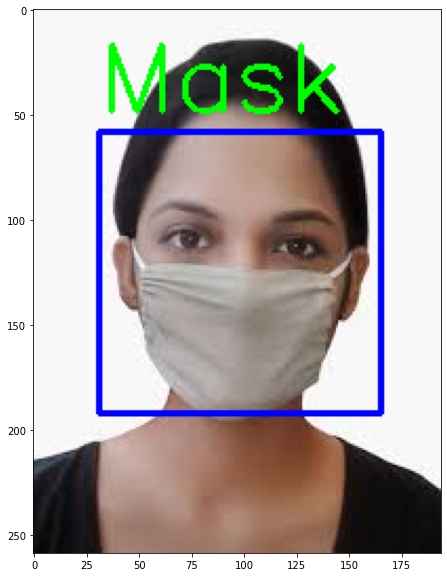

In [74]:
color_label = {0: (0, 0, 255), 1: (0, 255, 0), 2: (255, 0, 0)}
image = cv2.imread('../input/faces-with-masks/faces_with_mask/1006.jpg')
gray = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(gray, 1.1, 4)
out_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y+h, x:x+w]
    crop = cv2.resize(crop, (120, 120))
    crop = np.reshape(crop, [1, 120, 120, 3])/255.0
    mask_result = model.predict(crop)
    if mask_result > 0.5:
        label_Y = 1
    else:
        label_Y = 0
    cv2.rectangle(out_img, (x, y), (x+w, y+h), (color_label[0]), 2)
    cv2.putText(out_img, mask_label[label_Y], (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (color_label[1]), 2)
plt.figure(figsize=(10, 10))
plt.imshow(out_img)

### Для решения этой проблемы есть много разных вариантов. Мы начнем с самого простого и нересурсоемкого: OpenCV haar cascade.

### Он неплохо справляется с фронтальными лицами (есть разные модули).

### Создаем алгоритм, который находит лица на картинке и отмечаем их синим квадратом.

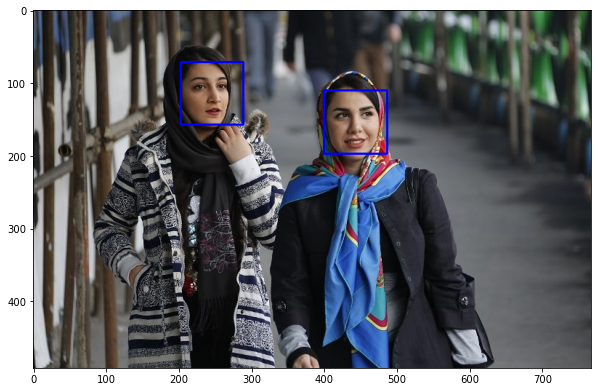

In [75]:
image = cv2.imread(
    '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0011.jpg')
gray = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
face_model = cv2.CascadeClassifier(
    '../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
faces = face_model.detectMultiScale(gray)  # returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # colored output image

# plotting
for (x, y, w, h) in faces:
    cv2.rectangle(out_img, (x, y), (x+w, y+h), (color_label[0]), 2)   # blue
plt.figure(figsize=(10, 10))
plt.imshow(out_img)

### Добавим рассчет расстояния между людьми на фото (MIN_DISTANCE) и оценку соблюдения этого условия: если дистанция соблюдена -  рамка зеленая, если нет - красная.Если лиц меньше 2, то выводится сообщение, что мало лиц.


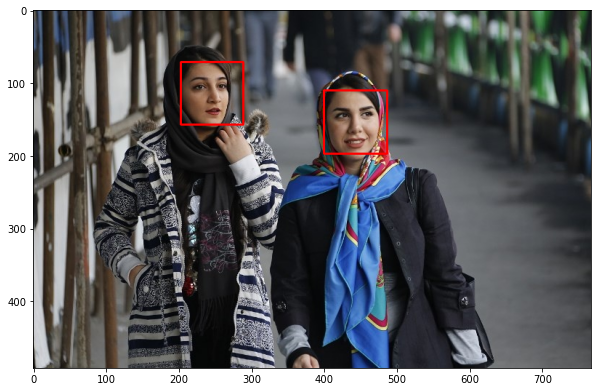

In [76]:
MIN_DISTANCE = 220

if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        if label[i] == 1:
            cv2.rectangle(out_img, (x, y), (x+w, y+h),
                          (color_label[2]), 2)  # red - if bad
        else:
            cv2.rectangle(out_img, (x, y), (x+w, y+h),
                          (color_label[1]), 2)  # green - if good
    plt.figure(figsize=(10, 10))
    plt.imshow(out_img)

else:
    print("No. of faces detected is less than 2")

### Добавляем нашу обученную модель и predictions:

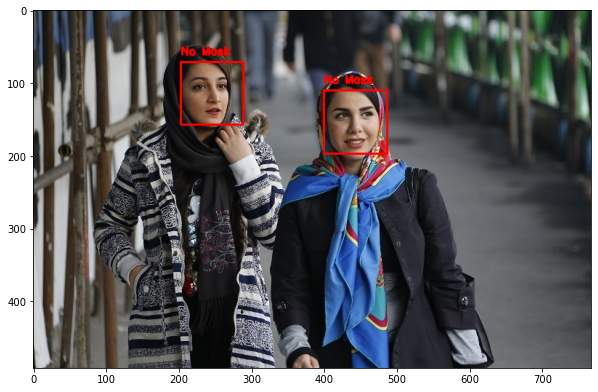

In [77]:
if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)
        if mask_result > 0.5:
            label_Y = 1
        if mask_result < 0.5:
            label_Y = 0
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, dist_label[label[i]], 2)
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(out_img)

else:
    print("No. of faces detected is less than 2")

In [78]:
mask_result

array([[2.3594156e-22]], dtype=float32)

In [79]:
print(len(faces))

2


### Проблема: не всегда Open CV haarCascade точно определяет все лица на фото (точность -+80%)

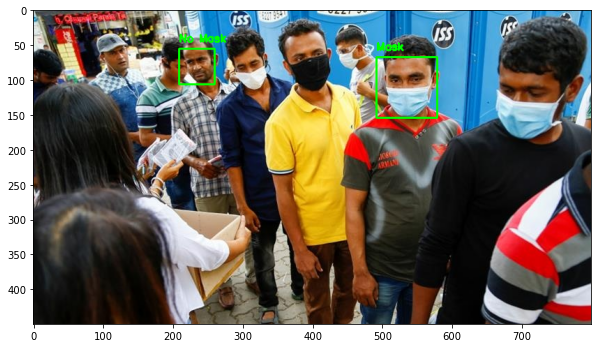

In [80]:
image = cv2.imread(
    '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0051.jpg')
gray = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
face_model = cv2.CascadeClassifier(
    '../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
faces = face_model.detectMultiScale(gray)
out_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)

        if mask_result > 0.5:
            label_Y = 1
        if mask_result < 0.5:
            label_Y = 0
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, dist_label[label[i]], 2)
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(out_img)

else:
    print("No. of faces detected is less than 2")

### На фото толпы проблема детекции лица стоит особо остро у haar cascade:

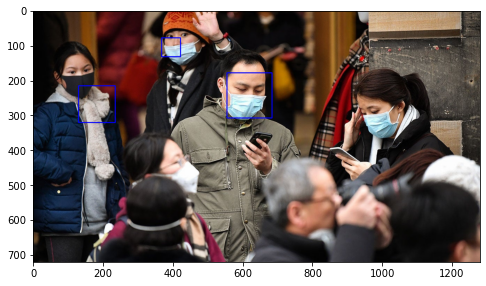

In [81]:
image = cv2.imread(
    "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0025.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_model.detectMultiScale(gray)
out_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

for (x, y, w, h) in faces:
    cv2.rectangle(out_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
plt.figure(figsize=(8, 8))
plt.imshow(out_img)

### Попробуем  вариант с MTCNN (предобученной нейронной сетью) для детектирования лиц.

### MTCNN очень полезна, так как может работать в режиме реального времени даже на небольших устройствах. После MTCNN было много алгоритмов,но он остается одним из лучших для обнаружения лиц (frontalface  лучше всего), с гораздо лучшей точностью, чем  Open CV (haar cascade).

In [82]:
# draw an image with detected objects
def draw_image_with_boxes(img, result_list):
    # load the image
    data = pyplot.imread(img)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='blue')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()

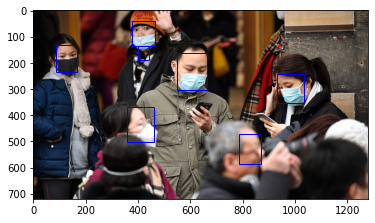

In [83]:
img = '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0025.jpg'
image = pyplot.imread(img)
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(image)
# display faces on the original image
draw_image_with_boxes(img, faces)

In [84]:
# вот такую информацию MTCNN выводит по каждому лицу, достаточно подробно:
faces

[{'box': [549, 163, 113, 141],
  'confidence': 0.9999876022338867,
  'keypoints': {'left_eye': (597, 227),
   'right_eye': (648, 230),
   'nose': (626, 260),
   'mouth_left': (595, 274),
   'mouth_right': (636, 279)}},
 {'box': [86, 133, 82, 101],
  'confidence': 0.9998760223388672,
  'keypoints': {'left_eye': (112, 179),
   'right_eye': (153, 173),
   'nose': (136, 191),
   'mouth_left': (120, 212),
   'mouth_right': (153, 209)}},
 {'box': [930, 244, 105, 108],
  'confidence': 0.9998440742492676,
  'keypoints': {'left_eye': (952, 291),
   'right_eye': (991, 275),
   'nose': (970, 314),
   'mouth_left': (962, 330),
   'mouth_right': (1001, 317)}},
 {'box': [377, 40, 87, 97],
  'confidence': 0.9985760450363159,
  'keypoints': {'left_eye': (396, 76),
   'right_eye': (434, 72),
   'nose': (412, 97),
   'mouth_left': (401, 115),
   'mouth_right': (432, 113)}},
 {'box': [784, 472, 85, 116],
  'confidence': 0.9085297584533691,
  'keypoints': {'left_eye': (816, 515),
   'right_eye': (848, 515

#### 'box' - выводит координаты лица, 'confidence' - уверенность в том, что это лицо.

### Как видим, результат детекции лиц гораздо лучше!

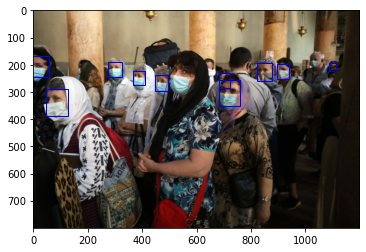

In [85]:
img = '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0044.jpg'
# load image from file
image = pyplot.imread(img)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(image)
draw_image_with_boxes(img, faces)

### А вот так MTCNN работает в связке с нашей моделью: сперва детектируются лица, затем измеряется расстояние между лицами (если Min расстояние не соблюдено - то рамки таких лиц красные, если Norm - то зеленые), затем анализируется каждое лицо через нашу обученную модель на предмет наличия маски на лице.

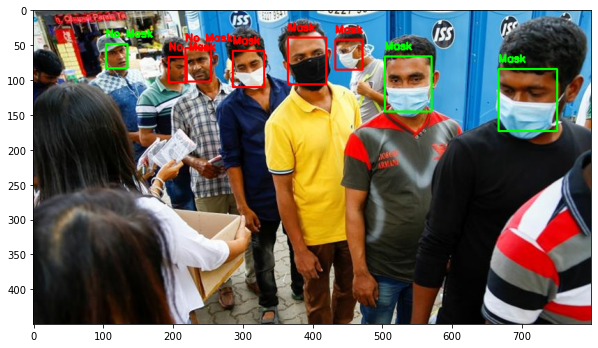

In [93]:
MIN_DISTANCE = 70
image = pyplot.imread(
    '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0051.jpg')
detector = MTCNN()
faces = detector.detect_faces(image)
out_img = image

if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i]["box"][:2], faces[j]["box"][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]["box"]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)
        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, dist_label[label[i]], 2)
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 2)
else:
    print("No. of faces detected is less than 2")
plt.figure(figsize=(10, 10))
plt.imshow(out_img)

In [87]:
faces[2]["box"] #координаты лица №2. Такие координаты мы и будем в дальнейшем использовать.

[667, 84, 84, 89]

#### Другой вариант оформления вывода информации после анализа:

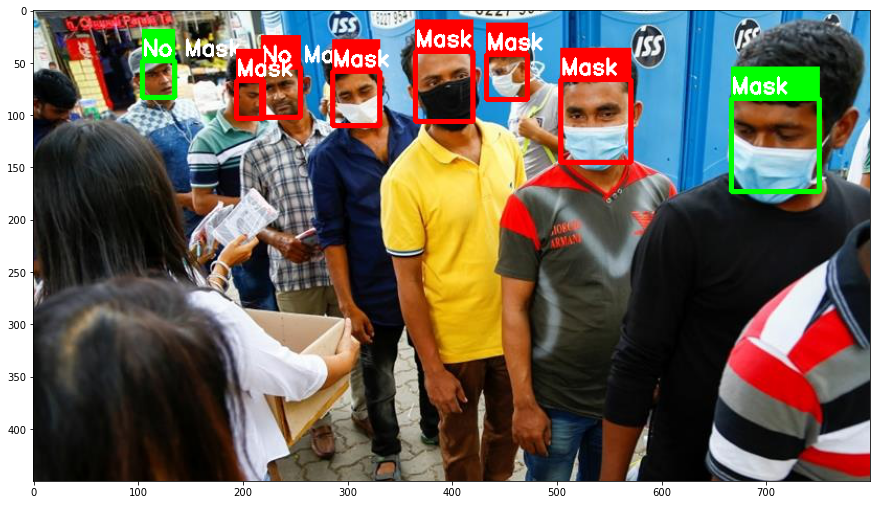

In [105]:
image = pyplot.imread(
    '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0051.jpg')
detector = MTCNN()

faces = detector.detect_faces(image)
out_img = image
plt.figure(figsize=(15, 15))

if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i]["box"][:2], faces[j]["box"][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]["box"]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)

        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 3)
        cv2.rectangle(out_img, (x, y-30), (x+w, y), dist_label[label[i]], -1)
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (color_label[4]), 2)
else:
    print("No. of faces detected is less than 2")
plt.imshow(out_img)

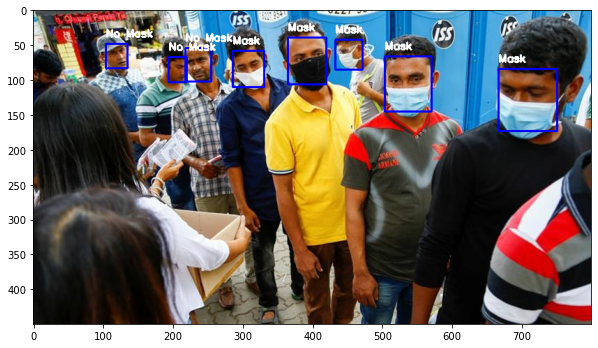

In [119]:
img = '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0051.jpg'
image = pyplot.imread(img)
detector = MTCNN()
faces = detector.detect_faces(image)
out_img = image

for i in range(len(faces)):
    (x, y, w, h) = faces[i]["box"]
    crop = out_img[y:y+h, x:x+w]
    crop = cv2.resize(crop, (120, 120))
    crop = np.reshape(crop, [1, 120, 120, 3])/255.0
    mask_result = model.predict(crop)

    if mask_result > 0.5:
        label_Y = 1
    elif mask_result < 0.5:
        label_Y = 0
    cv2.rectangle(out_img, (x, y), (x+w, y+h), (color_label[0]), 2)
    cv2.putText(out_img, mask_label[(label_Y)], (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color_label[4]), 2)

plt.figure(figsize=(10, 10))
plt.imshow(out_img)

### Изменим  код, чтобы он был применим и для 1 человека в кадре.

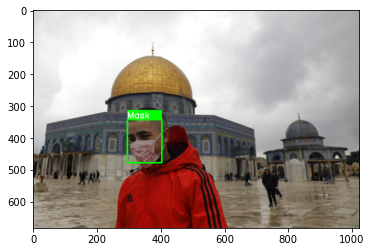

In [114]:
filename = '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0015.jpg'
image = pyplot.imread(filename)
detector = MTCNN()
faces = detector.detect_faces(image)
out_img = image

if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i]["box"][:2], faces[j]["box"][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    for i in range(len(faces)):
        (x, y, w, h) = faces[i]["box"]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)

        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 3)
        cv2.rectangle(out_img, (x, y-30), (x+w, y), dist_label[label[i]], -1)
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (color_label[4]), 2)

else:
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]["box"]
        crop = out_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (120, 120))
        crop = np.reshape(crop, [1, 120, 120, 3])/255.0
        mask_result = model.predict(crop)

        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0
        cv2.rectangle(out_img, (x, y), (x+w, y+h), dist_label[label[i]], 3)
        cv2.rectangle(out_img, (x, y-30), (x+w, y), dist_label[label[i]], -1)
        cv2.putText(out_img, mask_label[(
            label_Y)], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (color_label[4]), 2)

pyplot.imshow(out_img)

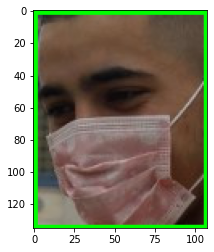

In [115]:
 pyplot.imshow(out_img[y:y+h,x:x+w]) 

### Создадим финальный код для работы с фото для вывода всей нужной нам информации: время, кол-во лиц в кадре, предупреждение, если людей больше 3+ (Х человек), анализ лиц на наличие масок, а также анализ на соблюдение социальной дистанции между людьми:

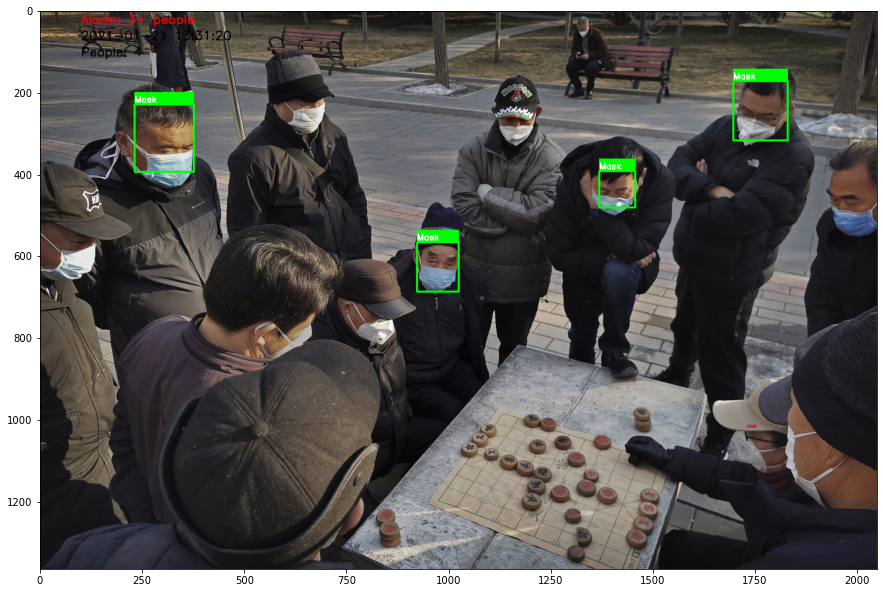

In [118]:
image = pyplot.imread('../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/0007.jpg')
detector = MTCNN()
faces = detector.detect_faces(image)
out_img = image
plt.figure(figsize=(15,15)) 
time_now = datetime.datetime.now().replace(microsecond=0)
cv2.putText(out_img,str(time_now),(100,70),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2)
cv2.putText(out_img, f"People: {len(faces)}",(100,110),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2)  

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i]["box"][:2],faces[j]["box"][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1    

    for i in range(len(faces)):
        (x,y,w,h) = faces[i]["box"]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(120,120))
        crop = np.reshape(crop,[1,120,120,3])/255.0
        mask_result = model.predict(crop) 
                          
        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0        
        cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[label[i]],3) 
        cv2.rectangle(out_img,(x,y-30),(x+w,y),dist_label[label[i]],-1)
        cv2.putText(out_img, mask_label[(label_Y)], (x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.7,(color_label[4]),2)           
            
else: 
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]["box"]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(120,120))
        crop = np.reshape(crop,[1,120,120,3])/255.0
        mask_result = model.predict(crop) 

        if mask_result > 0.5:
            label_Y = 1
        elif mask_result < 0.5:
            label_Y = 0        
        cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[label[i]],3) 
        cv2.rectangle(out_img,(x,y-30),(x+w,y),dist_label[label[i]],-1)
        cv2.putText(out_img, mask_label[(label_Y)], (x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.9,(color_label[4]),2)     

# Display alarm if number of people 3+:
if len(faces)>=3:
    cv2.putText(out_img,str("Alarm: 3+ people"),(100,30),cv2.FONT_HERSHEY_SIMPLEX,1,(color_label[2]),2)           
            
plt.imshow(out_img) 

### В vol.3 мы продолжим усовершенствовать наш алгоритм для работы с видео потоком.